In [1]:
from scipy.spatial.transform import Rotation 
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import display
%config InlineBackend.figure_format = 'retina'

In [2]:
def Pi(p:np.ndarray | list) -> np.ndarray:
    """convert from homogeneous coordinates to inhomogeneous coordinates

    subtract one coordinate"""
    if isinstance(p, np.ndarray):
        return p[:-1]/p[-1]
    elif isinstance(p, list):
        return [Pi(np.array(p_)) for p_ in p]

def PiInv(p:np.ndarray | list) -> np.ndarray:
    """convert from inhomogeneous coordinates to homogeneous coordinates

    add one coordinate with value 1"""
    if isinstance(p, np.ndarray):
        return np.vstack((p, np.ones(p.shape[1])))
    elif isinstance(p, list):
        return [PiInv(np.array(p_)) for p_ in p]

def projectpoints(K, R, t, Q):
    """project 3D points to 2D"""
    Rt = np.concatenate((R, t), axis=1)
    return Pi(K @ Rt @ PiInv(Q))

def crossOp(a:np.ndarray) -> np.ndarray:
    """crossproduct operator"""
    x = a[0].item()
    y = a[1].item()
    z = a[2].item()
    return np.array([[0, -z, y], [z, 0, -x], [-y, x, 0]])

In [3]:
R = np.array([[np.sqrt(1/2), -np.sqrt(1/2), 0],
              [np.sqrt(1/2), np.sqrt(1/2), 0],
                [0, 0, 1]])
f = 1000; beta = 0; alpha = 1; dx = 0.5*1920; dy = 0.5*1080
K = np.array([[f, beta*f, dx],
              [0, alpha*f, dy],
              [0, 0, 1]])
t = np.array([[0, 0, 10]]).T

In [25]:
# set numpy to print in a more readable way
# np.get_printoptions()
# np.set_printoptions(precision=4)
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [26]:
# 4.1 find the projection matrix P and the projections q
P = K @ np.concatenate((R, t), axis=1)
display(P)
# all the projections are the possible points that can be created
Q000 = np.array([[0, 0, 0]]).T
Q001 = np.array([[0, 0, 1]]).T
Q010 = np.array([[0, 1, 0]]).T
Q011 = np.array([[0, 1, 1]]).T
Q100 = np.array([[1, 0, 0]]).T
Q101 = np.array([[1, 0, 1]]).T
Q110 = np.array([[1, 1, 0]]).T
Q111 = np.array([[1, 1, 1]]).T
all_points = np.concatenate([Q000, Q001, Q010, Q011, Q100, Q101, Q110, Q111], axis=1)
projected_points = np.array([projectpoints(K, R, t, Q.reshape(-1,1)) for Q in all_points.T]).reshape(-1,2).T
projected_points

array([[707.107, -707.107, 960.000, 9600.000],
       [707.107, 707.107, 540.000, 5400.000],
       [0.000, 0.000, 1.000, 10.000]])

array([[960.000, 960.000, 889.289, 895.718, 1030.711, 1024.282, 960.000,
        960.000],
       [540.000, 540.000, 610.711, 604.282, 610.711, 604.282, 681.421,
        668.565]])

In [6]:
# by noticing what the project_points function does
# could achieve the same result with
Pi(P @ PiInv(Q000))

array([[960.],
       [540.]])

In [7]:
def normalize2d(p:np.ndarray):
    """normalize 2d points, finds the transformation T such that
    
    q_ih = T @ p_ih has mean = [0,0] and std = [1,1] for all q_i
    
    input: 2xN array of points
    """
    mu_x, mu_y = p.mean(axis=1)
    sigma_x, sigma_y = p.std(axis=1)
    T = np.array([[1 / sigma_x, 0, -mu_x / sigma_x],
                  [0, 1 / sigma_y, -mu_y / sigma_y],
                  [0, 0, 1]])
    return T

In [8]:
# 4.2 Q and q to estimate P with the DLT
def pest(Qs:np.ndarray, qs:np.ndarray, normalise=False) -> np.ndarray:
    """estimate P with the DLT (Direct Linear Transform)
    
    does not normalise the points to begin with
    """
    # normalise points
    if normalise:
        T = normalize2d(qs)
        qs = T @ PiInv(qs)

    n_Qs = Qs.shape[1]
    B = np.zeros((3*n_Qs, 12))
    for i, (Q, q) in enumerate(zip(Qs.T, qs.T)):
        q = PiInv(q.reshape(-1,1))
        Q = PiInv(Q.reshape(-1,1))
        s = q[-1]
            
        B[(i*3):(i*3)+3] = np.kron(Q, crossOp((q/s))).T
    u, s, vh = np.linalg.svd(B)
    V = vh.T
    P = V[:,-1].reshape((4, 3)).T
    if normalise:
        P = np.linalg.inv(T)@P
    return P
Qs = all_points.copy()
qs = projected_points.copy()
Pest = pest(Qs, qs, normalise=False)

In [27]:
q_est = np.array([Pi(Pest @ PiInv(Q.reshape(-1,1))) for Q in Qs.T]).reshape(-1,2).T
q_est

array([[960.000, 960.000, 889.289, 895.718, 1030.711, 1024.282, 960.000,
        960.000],
       [540.000, 540.000, 610.711, 604.282, 610.711, 604.282, 681.421,
        668.565]])

In [28]:
Pest2 = pest(Qs, qs, normalise=True)
q_est_normalised = np.array([Pi(Pest2 @ PiInv(Q.reshape(-1,1))) for Q in Qs.T]).reshape(-1,2).T
q_est_normalised

array([[960.000, 960.000, 889.289, 895.718, 1030.711, 1024.282, 960.000,
        960.000],
       [540.000, 540.000, 610.711, 604.282, 610.711, 604.282, 681.421,
        668.565]])

In [29]:
def RMSE(q_ref, q_est):
    """root mean square error"""
    return np.sqrt(np.mean((q_ref - q_est)**2))
print(RMSE(qs, q_est))
print(RMSE(qs, q_est_normalised))
# these errors correspond roughly to the expected number from the exercise sheet

1.534516729424152e-10
1.6077746776921858e-13


In [12]:
# 4.3
def checkerboard_points(n:int, m:int) -> np.ndarray:
    """create the points of a checkerboard

    the points lie on the plane z=0 by definition
    
    returns: a 3 x (n*m) array where the order does not matter"""
    Q = np.zeros((3, n*m))
    for i in range(n):
        for j in range(m):
            Q[:, i*m+j] = np.array([i-(n-1)/2, j-(m-1)/2, 0])
    return Q

In [13]:
# 4.4
R1 = Rotation.from_euler('xyz', [np.pi/10, 0, 0]).as_matrix()
R2 = Rotation.from_euler('xyz', [0, 0, 0]).as_matrix()
R3 = Rotation.from_euler('xyz', [-np.pi/10, 0, 0]).as_matrix()
Q_omega = checkerboard_points(10, 20)
Qa = R1 @ Q_omega
Qb = R2 @ Q_omega
Qc = R3 @ Q_omega

qa = Pi(P @ PiInv(Qa))
qb = Pi(P @ PiInv(Qb))
qc = Pi(P @ PiInv(Qc))

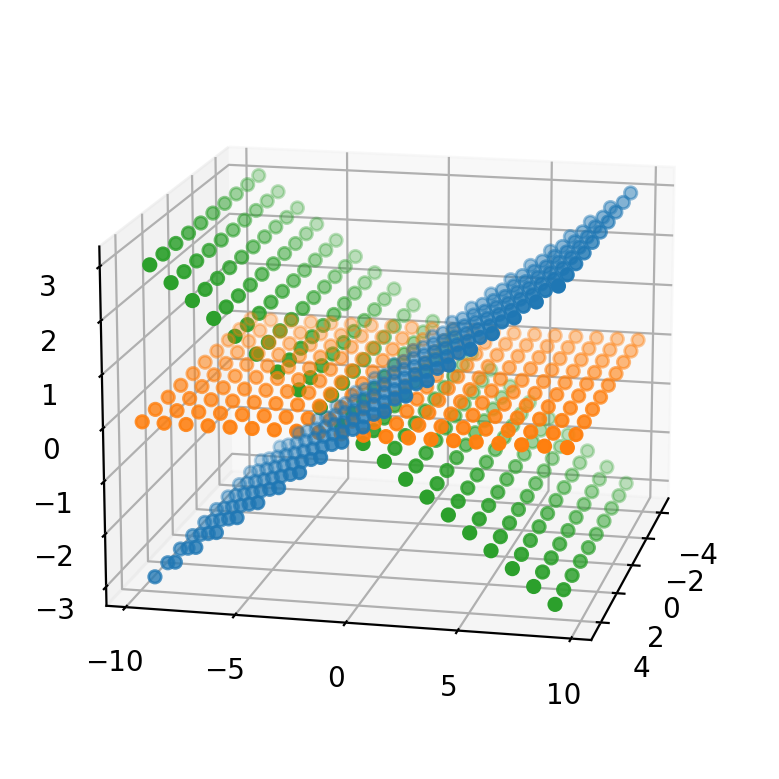

In [14]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(projection='3d')
elev = 15.0
azim = 12.5
ax.view_init(elev, azim)
ax.scatter(Qa[0], Qa[1], Qa[2])
ax.scatter(Qb[0], Qb[1], Qb[2])
ax.scatter(Qc[0], Qc[1], Qc[2])
plt.show()

In [15]:
def cross_op(x:np.ndarray):
    x1i = x[0].item()
    y1i = x[1].item()
    return np.array([[0, -1, y1i], [1, 0, -x1i], [-y1i, x1i, 0]])


def hest(q1s:np.ndarray, q2s:np.ndarray, normalise=True) -> np.ndarray:
    """estimate homography from 2 sets of points
    
    q1: 2xN array of points in image 1
    q2: 2xN array of points in image 2

    returns: 3x3 homography matrix H
    """
    N = q1s.shape[0]+1
    K = q1s.shape[1]
    B = np.zeros((N*K, N**2))
    
    if normalise:
        # Get normalization matrices and normalize points)
        T1, T2 = normalize2d(q1s), normalize2d(q2s[:2])
        q1s, q2s = Pi(T1 @ PiInv(q1s)), Pi(T2 @ PiInv(q2s[:2]))

    for i, (q1, q2) in enumerate(zip(q1s.T, q2s.T)):
        q1 = PiInv(q1.reshape(-1, 1)); q2 = PiInv(q2.reshape(-1, 1))
        B[i*N:(i+1)*N] = np.kron(q2.T, cross_op(q1))
        
    U, S, Vh = np.linalg.svd(B)
    V = Vh.T
    H_est = V[:,-1].reshape(3,3).T
    # should normalise before doing the svd
    frob_norm = np.linalg.norm(H_est, "fro")
    assert np.allclose(frob_norm, 1), "Something is wrong..."

    # Either normalized or non-normalized homography estimate
    return np.linalg.inv(T1) @ H_est @ T2 if normalise else H_est

In [16]:
# 4.5
def estimateHomographies(Q_omega: np.array, qs) -> list[np.array]:
    assert Q_omega.shape[0] == 3, f"""Q_omega must be 3D imhomogenous points but has shape: {Q_omega.shape}"""
    
    # Construct Q tilde.
    Q_tilde = Q_omega.copy()
    Q_tilde[-1] = 1

    # Estimate homographies.
    Hs = [hest(qi, Q_tilde, normalise=True) for qi in qs]

    return Hs
    
Hs = estimateHomographies(Q_omega, [qa, qb, qc])
Hs

[array([[ 4.13764931e+01, -2.19924805e+01,  5.61745898e+02],
        [ 4.13764931e+01,  4.91157663e+01,  3.15982068e+02],
        [-2.09802722e-17,  1.80821905e-02,  5.85151977e-01]]),
 array([[ 4.08248290e+01, -4.08248290e+01,  5.54256258e+02],
        [ 4.08248290e+01,  4.08248290e+01,  3.11769145e+02],
        [-1.88557745e-17, -2.60131072e-17,  5.77350269e-01]]),
 array([[-4.13764931e+01,  5.67102863e+01, -5.61745898e+02],
        [-4.13764931e+01, -2.95870005e+01, -3.15982068e+02],
        [-4.74893704e-17,  1.80821905e-02, -5.85151977e-01]])]

In [17]:
### Now we can test these homography matrices, as qij = Hi @ Q_tilde.
Q_tilde = np.vstack((Q_omega[:2,:], np.ones(len(Q_omega[0]))))
# Estimate using the H matrices
qa_est_h = Hs[0] @ Q_tilde
qb_est_h = Hs[1] @ Q_tilde
qc_est_h = Hs[2] @ Q_tilde
# Translate to inhomogenous coordinates
qa_est = qa_est_h[0:2, :]/qa_est_h[2, :]
qb_est = qb_est_h[0:2, :]/qb_est_h[2, :]
qc_est = qc_est_h[0:2, :]/qc_est_h[2, :]
print("Relative error:", np.sum((qa-qa_est)/np.linalg.norm(qa)))
print("Relative error:", np.sum((qb-qb_est)/np.linalg.norm(qb)))
print("Relative error:", np.sum((qc-qc_est)/np.linalg.norm(qc)))

Relative error: 2.358631412260956e-15
Relative error: -1.5763808979818649e-15
Relative error: 2.3434680377232947e-15


In [18]:
# 4.6
def make_V(Hs):
    V = make_Vrow(Hs[0])
    for i in range(1,len(Hs)):
        V = np.vstack([V,make_Vrow(Hs[i])])
    return V
    
def make_Vrow(H):
    v12 = np.array([H[0,0]*H[0,1],H[0,0]*H[1,1]+H[1,0]*H[0,1],H[1,0]*H[1,1],
                   H[2,0]*H[0,1]+H[0,0]*H[2,1],H[2,0]*H[1,1]+H[1,0]*H[2,1],H[2,0]*H[2,1]])
    v11 = np.array([H[0,0]*H[0,0],H[0,0]*H[1,0]+H[1,0]*H[0,0],H[1,0]*H[1,0],
                   H[2,0]*H[0,0]+H[0,0]*H[2,0],H[2,0]*H[1,0]+H[1,0]*H[2,0],H[2,0]*H[2,0]])
    v22 = np.array([H[0,1]*H[0,1],H[0,1]*H[1,1]+H[1,1]*H[0,1],H[1,1]*H[1,1],
                   H[2,1]*H[0,1]+H[0,1]*H[2,1],H[2,1]*H[1,1]+H[1,1]*H[2,1],H[2,1]*H[2,1]])
    V = np.vstack([v12,v11-v22])
    return V
    
def estimate_b(Hs):
    # Get V
    V = make_V(Hs)
    _,_,VT = np.linalg.svd(V) # SVD!
    # Solution to SVD
    b = VT[-1] # b = [B11, B12, B22, B13, B23, B33].T
    return b

In [19]:
Btrue = np.linalg.inv(K).T@np.linalg.inv(K)
b = estimate_b(Hs)
print(b)
B11, B12, B22, B13, B23, B33 = b[0], b[1], b[2], b[3], b[4], b[5]
B = np.array([[B11, B12, B13],
              [B12, B22, B23],
              [B13, B23, B33]])
B = (B / B[-1][-1]) * Btrue[-1][-1] # Scale the two matrices to same scale
print("Relative Error", np.linalg.norm(Btrue-B)/np.linalg.norm(Btrue))
print("B\n------------------------------- \n",B)
print("B_true:\n-------------------------------\n",Btrue)

[-4.51834392e-07 -1.16467030e-21 -4.51834392e-07  4.33761016e-04
  2.43990572e-04 -9.99999876e-01]
Relative Error 1.2029121019467333e-17
B
------------------------------- 
 [[ 1.00000000e-06  2.57764863e-21 -9.60000000e-04]
 [ 2.57764863e-21  1.00000000e-06 -5.40000000e-04]
 [-9.60000000e-04 -5.40000000e-04  2.21320000e+00]]
B_true:
-------------------------------
 [[ 1.0000e-06  0.0000e+00 -9.6000e-04]
 [ 0.0000e+00  1.0000e-06 -5.4000e-04]
 [-9.6000e-04 -5.4000e-04  2.2132e+00]]


In [20]:
# 4.7
def estimateIntrinsics(Hs:list):
    """estimate the intrinsics

    Hs: list of homographies

    returns: K"""
    # b = [B11 B12 B22 B13 B23 B33]

    b = estimate_b(Hs)
    # Use Zhang et al appendix B
    deltay = (b[1] * b[3] - b[0] * b[4]) / (b[0] * b[2] - b[1]**2)
    lambda_ = b[5] - (b[3]**2 + deltay * (b[1] * b[3] - b[0] * b[4])) / b[0]
    f = np.sqrt(lambda_ / b[0])
    alphaf = np.sqrt(lambda_ * b[0] / (b[0] * b[2] - b[1]**2))
    betaf = - b[1] * f**2 * alphaf / lambda_
    deltax = betaf * deltay / alphaf - b[3] * f**2 / lambda_
    alpha = alphaf / f
    beta = betaf / f

    K = np.array([
        [f, beta*f, deltax],
        [0, alpha*f, deltay],
        [0, 0, 1]
    ])
    return K
K = estimateIntrinsics(Hs)
K

array([[ 1.00000000e+03, -2.57764863e-12,  9.60000000e+02],
       [ 0.00000000e+00,  1.00000000e+03,  5.40000000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [37]:
# 4.8
def estimateExtrinsics(
        K: np.array, 
        Hs: list[np.array]
    ) -> tuple[list[np.array], list[np.array]]:
    
    def estimateRt(
            H: np.array, 
            Kinv: np.array
        ) -> tuple[np.array]:
        lambdai = (np.linalg.norm(Kinv @ H[:, 0]) + np.linalg.norm(Kinv @ H[:, 1])) / 2
        lambdai_inv = 1 / lambdai
        t = lambdai_inv * Kinv @ H[:, 2]
        
        # Correct for flipped solutions, i.e., behind the camera.
        if t[-1] < -1e-7:
            return estimateRt(-H, Kinv)
        else:
            r0 = lambdai_inv * Kinv @ H[:, 0]
            r1 = lambdai_inv * Kinv @ H[:, 1]
            r2 = np.cross(r0, r1)
            R = np.array([r0, r1, r2]).T
        return R, t

    Kinv = np.linalg.inv(K)
    Rs, ts = list(), list()
    for H in Hs:
        R, t = estimateRt(H, Kinv)
        Rs.append(R)
        ts.append(t)
    
    return Rs, ts

In [38]:
# 4.8.2
def calibratecamera(qs: list[np.array], Q: np.array) -> tuple[np.array]:
    """qs is a list of homogenous points and 
    Q is a 3xn array 3D imhomogenous points."""
    
    Hs = estimateHomographies(Q, qs)
    K = estimateIntrinsics(Hs)
    Rs, ts = estimateExtrinsics(K, Hs)
    return K, Rs, ts

K, Rs, ts = calibratecamera([qa, qb, qc], Q_omega)

In [39]:
K, Rs, ts

(array([[1000.000, -0.000, 960.000],
        [0.000, 1000.000, 540.000],
        [0.000, 0.000, 1.000]]),
 [array([[0.707, -0.672, 0.219],
         [0.707, 0.672, -0.219],
         [-0.000, 0.309, 0.951]]),
  array([[0.707, -0.707, -0.000],
         [0.707, 0.707, 0.000],
         [-0.000, -0.000, 1.000]]),
  array([[0.707, -0.672, -0.219],
         [0.707, 0.672, 0.219],
         [0.000, -0.309, 0.951]])],
 [array([0.000, 0.000, 10.000]),
  array([0.000, 0.000, 10.000]),
  array([0.000, 0.000, 10.000])])

This seems correct :)